In [23]:
import pandas as pd
import preprocessor as prep_t 
import spacy
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Goal

**The aim of this notebook is to explore and analyze the data of disaster tweets to get first insights.**

# Data set

In [14]:
df = pd.read_csv('../data/train.csv')

df.shape

(7613, 5)

## Missing values

There are an important amount of missing values in loation column

In [15]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Target values

Classes are balanced

In [6]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
df.keyword.sample(10)

6885            traumatised
5946              screaming
3692               fatality
1339    burning%20buildings
2443             derailment
6284                  storm
3455               exploded
980              body%20bag
5175             obliterate
2374                 derail
Name: keyword, dtype: object

## Location

There are 3341 unique location values

In [19]:
df['location'].nunique()

3341

Location could be a city or a country

In [16]:
df['location'].value_counts()[:5]

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64

There are some misspelled location values

In [17]:
df['location'].value_counts()[-5:]

| CA Û¢ GA  |                            1
Netherlands                               1
Canberra, Australian Capital Territory    1
the local dump                            1
Numenor                                   1
Name: location, dtype: int64

## Keyword

There are 221 unique "keywords"

In [18]:
df['keyword'].nunique()

221

There are some keywords that make us think of "disaster".

In [21]:
df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

We check if there is some relation between target and keyword. We represent target mean per keyweord

We observe that tweets with the keywords such as "oil%20spill" or "outbreak" are actually disaster tweets. The column "keyword" seems to be a good variable to predict target values

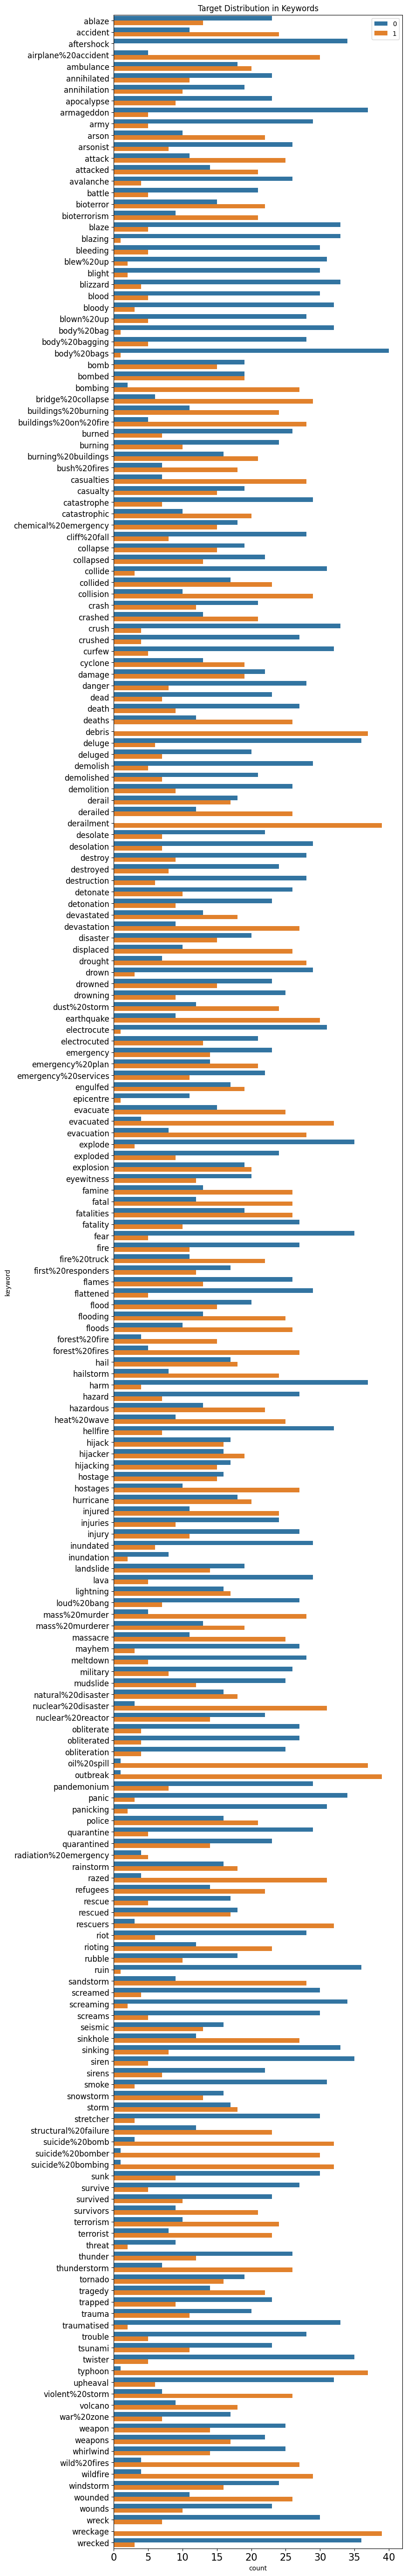

In [22]:
df['target_mean'] = df.groupby('keyword')['target'].mean()

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df.drop(columns=['target_mean'], inplace=True)

**Length of tweets**

In [24]:
df['len_text'] = df['text'].map(len)

Disaster tweets tend to be little bit longer

In [25]:
fig = px.histogram(df, x="len_text", color="target", title='Disribution of tweets length vs targets',
                  barmode='overlay', opacity=0.7)
fig.show()

**Tokens**

We use here simple tokenization by splitting words by white spaces. To be more accurate, we could also use more sophisticated tokenization (spaCy, NLTK, ...)

In [27]:
def simple_tokens_length(text):
    l = len(text.split(' '))
    return l

In [30]:
df['nb_tokens'] = df['text'].map(simple_tokens_length)

In [31]:
fig = px.histogram(df, x="nb_tokens", color="target", title='Disribution of # tokens vs targets',
                  barmode='overlay', opacity=0.7)
fig.show()

In [30]:
df.isnull().sum()

id                    0
keyword              61
location           2533
text                  0
target                0
is_true_keyword       0
gpe_extracted      5016
dtype: int64

In [31]:
doc = nlp('USA is a country')

In [32]:
for ent in doc.ents:
    print(ent.label_)

In [33]:
df[df.location.notnull()&df.gpe_extracted.isnull()].location.value_counts()

USA                              104
Nigeria                           28
Mumbai                            22
Worldwide                         19
Everywhere                        15
                                ... 
Lytham St Anne's                   1
??? ?? ???????                     1
LA                                 1
eBooks, North America              1
golborne, north west england.      1
Name: location, Length: 1923, dtype: int64

In [34]:
df.loc[df.location.isin(['USA', 'Wordwide']), 'gpe_extracted'] =  df.loc[df.location.isin(['USA', 'Wordwide']), 'location']

In [35]:
df.isnull().sum()

id                    0
keyword              61
location           2533
text                  0
target                0
is_true_keyword       0
gpe_extracted      4912
dtype: int64

USA = United States

Embedding ?

# Meta data

In [36]:
import numpy as np

In [37]:
# word_count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [38]:
# mean_word_length
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [39]:
# 
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

In [40]:
import string
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [41]:
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [42]:
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [43]:
df[df.mention_count > 0]

id  keyword                location  \
31       48   ablaze              Birmingham   
36       54   ablaze                Pretoria   
43       63   ablaze                     NaN   
54       78   ablaze                   Abuja   
57       81   ablaze       Sao Paulo, Brazil   
...     ...      ...                     ...   
7577  10829  wrecked  #NewcastleuponTyne #UK   
7578  10830  wrecked                     NaN   
7581  10833  wrecked                 Lincoln   
7596  10851      NaN                     NaN   
7609  10870      NaN                     NaN   

                                                   text  target  \
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...       1   
36    @PhDSquares #mufc they've built so much hype a...       0   
43         SOOOO PUMPED FOR ABLAZE ???? @southridgelife       0   
54    Noches El-Bestia '@Alexis_Sanchez: happy to se...       0   
57    Set our hearts ablaze and every city was a gif...       0   
...                                                 ...     ...   
7577  @widda16 ... He's gone. You can relax. I thoug...       0   
7578   @jt_ruff23 @cameronhacker and I wrecked you both       0   
7581  @engineshed Great atmosphere at the British Li...       0   
7596  RT @LivingSafely: #NWS issues Severe #Thunders...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   

      is_true_keyword gpe_extracted  word_count  mean_word_length  char_count  \
31              False    Birmingham           5         10.200000          55   
36              False      Pretoria          21          4.857143         122   
43              False           NaN           6          6.500000          44   
54              False          None          15          7.733333         130   
57              False     Sao Paulo          22          4.681818         124   
...               ...           ...         ...               ...         ...   
7577            False            UK          21          4.142857         107   
7578            False           NaN           7          6.000000          48   
7581            False          None          13          7.076923         104   
7596            False           NaN          18          6.500000         134   
7609            False           NaN          20          5.300000         125   

      punctuation_count  hashtag_count  mention_count  
31                    6              0              1  
36                    4              1              1  
43                    5              0              1  
54                   20              0              1  
57                    7              0              1  
...                 ...            ...            ...  
7577                  8              1              1  
7578                  3              0              2  
7581                  8              0              1  
7596                 14              5              1  
7609                  5              0              2  

[2039 rows x 13 columns]

In [44]:
t = df['text'].sample().values[0]

In [45]:
t = """
'@Cameron_WATE\n Parents of Colorado theater shooting victim fear copycat massacre\n\n http://t.co/LvlH3W3aWO\n#Antioch\n\n http://t.co/vIwXY1XDYK'
"""

In [46]:
parsed_tweet = p.parse(t)

In [47]:
parsed_tweet.urls

[(85:107) => http://t.co/LvlH3W3aWO, (119:141) => http://t.co/vIwXY1XDYK]

In [48]:
df['url_count'] = df['text'].apply(lambda x: len(p.parse(x).urls) if np.all(pd.notnull(p.parse(x).urls)) else 0)

In [49]:
def length_url(text):
    parsed_tweet = p.parse(text)
    c= 0
    if np.any(pd.notnull(parsed_tweet.urls)):
        for i in range(len(parsed_tweet.urls)):
            c = c+ len(parsed_tweet.urls[i].match)
    else:
        pass
    
    return c

In [50]:
df['len_url'] = df['text'].apply(lambda x: length_url(x))

In [51]:
#import emoji
#
#def find_emoji(text):
#    emo_text=emoji.demojize(text)
#    line=re.findall(r'\:(.*?)\:',emo_text)
#    return line
#
#def extract_emojis(s):
#    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)
#
#df['emojis'] = df['text'].apply(lambda x: extract_emojis(x))
#
#df['emojis'].value_counts()

# Preprocessing

## Missing values

In [52]:
df = df.fillna('')

## Clean text

In [53]:
for i in df.text.sample(10):
    print(i)
    print('\n' + '-'*100)

#retweet Cameroon repatriating about 12000 Nigerian refugees due to Boko Haram http://t.co/wvVgmejA7l

----------------------------------------------------------------------------------------------------
IMAGINE A DOCTOR TREATING AN #EBOLA PATIENT WITHOUT EVER PLACING HIMSELF IN HARM'S WAY. http://t.co/dliZfkk30Y

----------------------------------------------------------------------------------------------------
@RockBottomRadFM Is one of the challenges on Tough Enough rescuing people from burning buildings?

----------------------------------------------------------------------------------------------------
Hi yall this poem is called is the one about the snowstorm when we meet in space and that one time it rained. Thx. Ur watching disney chann

----------------------------------------------------------------------------------------------------
http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice &amp; see how a #solicitor can help #OtleyHour

----------

In [54]:
import re

In [55]:
df['cleaned_text']=df['text'].apply(lambda x:re.sub(r"(.*[a-zA-Z]?)\x89[^\W]*([a-zA-Z]?.*)", r"\1, \2", x))

In [56]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

In [57]:
df['cleaned_text'] = df['cleaned_text'].map(p.clean)

In [58]:
#df['text_clean'] = df['text'].map(p.clean)

In [59]:
#for i in df['cleaned_text']:
#    print(i)

In [60]:
#for i in df['text_clean']:
#    print(i)

In [61]:
for i in df['cleaned_text']:
    print(i)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida #T

Gulfport Energy - All-In Realizations Fall Off A Cliff
*Jumps off of a cliff while drinking tea* This is how British people fall off cliffs.
627% but if they had lower striked than 16 I would have gone even further OTM. This could really fall off a cliff.
That sounds like a really bad idea I like Yoenis but I feel like his production could fall off a huge cliff.
'I'm there!' Bride &amp; Groom on mountain cliff edge. Ha Ha just kidding. I WILL NOT EVER be there. Ha Ha -
ESN : Cilla Black died of stroke after fall in Spain: Sir Cliff revealed he was due to visit her in Spain next,
#NowPlaying * Cliff Richard - I Could Easily Fall (In Love With You) (&amp; Shadows) * #Internet #Nieuws #Radio On
Runaway Minion Causes Traffic Collapse in Dublin
Time collapse is such a cool video technique.
Would a paramedic really do that? Leave someone inside a building that's about to collapse/blow up?
I don't see the option to buy the full collapse vinyl with tee bundle just the waiting?
Warne Ponting sh

I liked a video Huge Building Explosion at 2500fps - The Slow Mo Guys
Large explosion rocks aluminum plant in southeast Missouri Re:Naomi-No Logo
...don't think I've ever been this close to a mental explosion in so long
GAElite 0 Explosion Greg 2 [Top 3rd] [0 Out] [0 balls] [0 strikes] ... No one on [P: #16 Morgan Orchard] [B: ]
ITS A TIE DYE EXPLOSION ON IG HELP ME. IM DROWNING IN TIE DYE
Exploring New Worlds: Three Moments of an Explosion by China Miville
MORE--&gt;OSHA officers on siteinvestigating Noranda explosion -KFVS12 News Cape Girardeau Carbondale Poplar Bluff
A Time-Lapse Map of Every Nuclear Explosion Since 1945 - by Isao Hashimoto #War #atomicbomb
lets get a dope picture together and have the dopest explosion ????
Big Data and Social Information explosion: The Union That Could Evolve Your Retail Strategy...HUa
Aspiring musician &amp; song writer shares her talent at the GMMBC Youth Explosion on this past Saturday.
I hope he does. And I hope you die in the explosion too
A P

All injuries Pre Foster/Floyd. Those will be covered next week.
What a fucking idiot. He had a gun &amp; a hatchet yet there were still no serious injuries. Glad police terminated him.
Trauma injuries involving kids and sport usually cycling related: Director Trauma NS #NS
O-line and pass rush. Rest of roster is stout barring injuries
Diego Costa needs to stop getting injuries urg
4 Common Running Injuries and How to Avoid Them
Enjoying a little golf this summer? Take care to avoid injury -- back and shoulder injuries can happen quickly
nflexpertpicks: Michael Floyd's hand injury shouldn't devalue his fantasy stock: Michael Floyd's damaged digits won... ,
Rory McIlroy to Test Ankle Injury in Weekend Practice #chinadotcom #sports
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring
JOBOOZOSO: USAT usatoday_nfl Michael Floyd's hand injury shouldn't devalue his fantasy stock
Jack Wilshere has poor injury recordand his off field behaviors doesn't help.#Ar

The Seven Seas - Wreck of the Giannis D. sunk after hitting a submerged reef in the,
Hank Williams Jr. - 'Country Boys Can Survive' (Official Music Video) via
Parental experience may help coral offspring survive climate change: Preconditioning adult corals to increased...
and I don't have any classes together and I'm not sure if I'll be able to survive
I have my final tomorrow ?????? . Ish is stressful but I'll survive
AHH forgot my headphones how am I supposed to survive a day without music AYHHHHHDJJFJRJJRDJJEKS
10 Ways To Survive and Escape Martial Law | World
How to Survive in the Markets #oil #investing #money #trading #forex #gold #silver #business
So much shit has happened today wtf idk how I survive thruuu it all
Ended today's staff meeting with the teacher version of 'I Will Survive' #tootrue
how will I survive without dorrian
If I survive tonight. I wouldn't change one thing. ??
3 Things All Affiliate Marketers Need To Survive Online - Every affiliate marketer is always...
DO

In [62]:
from transformers import DistilBertTokenizer, DistilBertModel

In [63]:
from transformers import BertTokenizer

In [64]:
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [65]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [66]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [67]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [68]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [69]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [70]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [71]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

In [72]:
type(encoding)

dict

In [73]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [74]:
encoding['input_ids'][0]

tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [75]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

inverse tokenization to have a look at special tokens

In [76]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [77]:
token_lens = []
for txt in df.cleaned_text:
    tokens = tokenizer.encode(txt, max_length=32)
    token_lens.append(len(tokens))

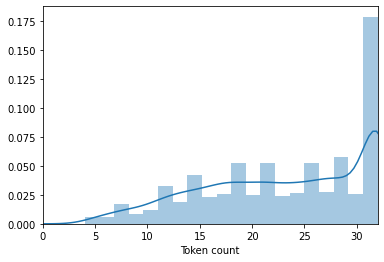

In [78]:
sns.distplot(token_lens)
plt.xlim([0, 32]);
plt.xlabel('Token count');

In [79]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [80]:
import torch

In [81]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [83]:
model = model.to(device)

In [84]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [85]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [86]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.cleaned_text.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
    )

BATCH_SIZE = 16
MAX_LEN = 32
train_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [87]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [88]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#loss_fn = nn.CrossEntropyLoss().to(device)

In [89]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [90]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [91]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [92]:
# Store the average loss after each epoch so we can plot them.
loss_values = []

In [99]:
#for step, batch in enumerate(train_data_loader):
#    
#
#        input_ids = d["input_ids"].to(device)
#        attention_mask = d["attention_mask"].to(device)
#        targets = d["targets"].to(device)

In [100]:
train_data_loader = create_data_loader(df[:200], tokenizer, MAX_LEN, BATCH_SIZE)

In [101]:
val_data_loader = create_data_loader(df[:100], tokenizer, MAX_LEN, BATCH_SIZE)

In [102]:
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_data_loader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_data_loader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_data_loader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in val_data_loader:
        
        # Add batch to GPU
        #batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        #b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['targets'].to(device)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...

  Average training loss: 0.71
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.89
  Validation took: 0:00:04

Training complete!


In [130]:
#print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [151]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [152]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])


In [153]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [154]:
from transformers import BertModel

In [155]:
%%time
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [156]:
%%time
#bert_model = DistilBertModel.from_pretrained("distilbert-base-cased")
bert_model = BertModel.from_pretrained("bert-base-cased")

CPU times: user 1.38 s, sys: 347 ms, total: 1.73 s
Wall time: 2.45 s


In [157]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [158]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [159]:
bert_model.config.hidden_size

768

In [160]:
pooled_output.shape

torch.Size([1, 768])

In [161]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [162]:
df.shape[0]//16

475

In [163]:
len(train_data_loader)

476

In [164]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        #self.embed = nn.Embedding(vocab_size, embed_size)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [166]:
model = SentimentClassifier(2)
model = model.to(device)

In [167]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 64])
torch.Size([16, 64])


In [85]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

NameError: name 'train_data_loader' is not defined

In [169]:
model = model.train()

In [171]:
#for d in train_data_loader:
#    input_ids = d["input_ids"].to(device)
#    attention_mask = d["attention_mask"].to(device)
#    targets = d["targets"].to(device)
#    outputs = model(
#          input_ids=input_ids,
#          attention_mask=attention_mask)

In [172]:
def train_epoch(model,
                data_loader,
                loss_fn,
                optimizer,
                device,
                scheduler,
                n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [173]:
def eval_model(model, data_loader, loss_fn, device, n_examples): 
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [107]:
from collections import defaultdict
from textwrap import wrap

In [176]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
#val_acc, val_loss = eval_model(
#  model,
#  val_data_loader,
#  loss_fn,
#  device,
#  len(df_val)
#)
#print(f'Val   loss {val_loss} accuracy {val_acc}')
#print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
#history['val_acc'].append(val_acc)
#history['val_loss'].append(val_loss)
    if train_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = train_acc
#  

Epoch 1/2
----------
Train loss 0.6248519699864027 accuracy 0.6819913306186786


NameError: name 'val_acc' is not defined

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased')
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits

TypeError: 'BertTokenizer' object is not callable

In [ ]:
log

In [34]:
import re

df['text_clean'] = df['text'].map(p.clean)

df['text_clean_tfidf'] = df['text_clean'].apply(lambda x: re.sub('[^\wÀ-ÿ\%\'\.\,]', ' ', x))

import spacy

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

def lemmatization(text, nlp):
    doc = nlp(text)
    return " ".join([d.lemma_ for d in doc])

df['text_clean_tfidf'] = df['text_clean_tfidf'].apply(lambda x: lemmatization(x, nlp))

for i in df.text_clean_tfidf.sample(10):
    print(i)
    print('\n' + '-'*100)

df.keyword.nunique()

df[df.target == 1].location.value_counts()

In [ ]:
B

In [44]:
df['location'] = df['location'].str.lower()

In [45]:
one_hot = pd.get_dummies(df['keyword'], drop_first=True)

In [46]:
df = df.drop(columns=['keyword'])
df = pd.concat([df, one_hot], axis = 1)

In [47]:
corpus = (df['text_clean_tfidf'] + df['location']).values

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=10)
X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())

In [49]:
X.shape

(7613, 1460)

In [50]:
df = df.drop(columns=["text", "text_clean", "text_clean_tfidf", "location"])

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X = df.drop(columns=['id', 'target'])
y = df[['target']]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.20, random_state = 42)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
clf = RandomForestClassifier()

In [56]:
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 

In [ ]:
pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import auc, precision_score, recall_score, f1_score

In [ ]:
precision_score(pred, y_test.target)

In [ ]:
recall_score(pred, y_test.target)

In [ ]:
f1_score(pred, y_test.target)